# Simple time series models

This notebook is based on [this course](https://github.com/Yorko/mlcourse_open/tree/master/jupyter_english/topic09_time_series) code and datasets. Some code has been ported to the Torchlite lib their usage is shown below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from itertools import product
from IPython.display import display

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

import torchlite.data.fetcher as fetcher
import torchlite.pandas.time_series as tts
import torchlite.matplotlib.models_plot as tmplot

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext autoreload
%autoreload 2

File already exists.
File already exists.


,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


,GEMS_GEMS_SPENT
Time,
2017-05-01,1199436
2017-05-02,1045515
2017-05-03,586111
2017-05-04,856601
2017-05-05,793775


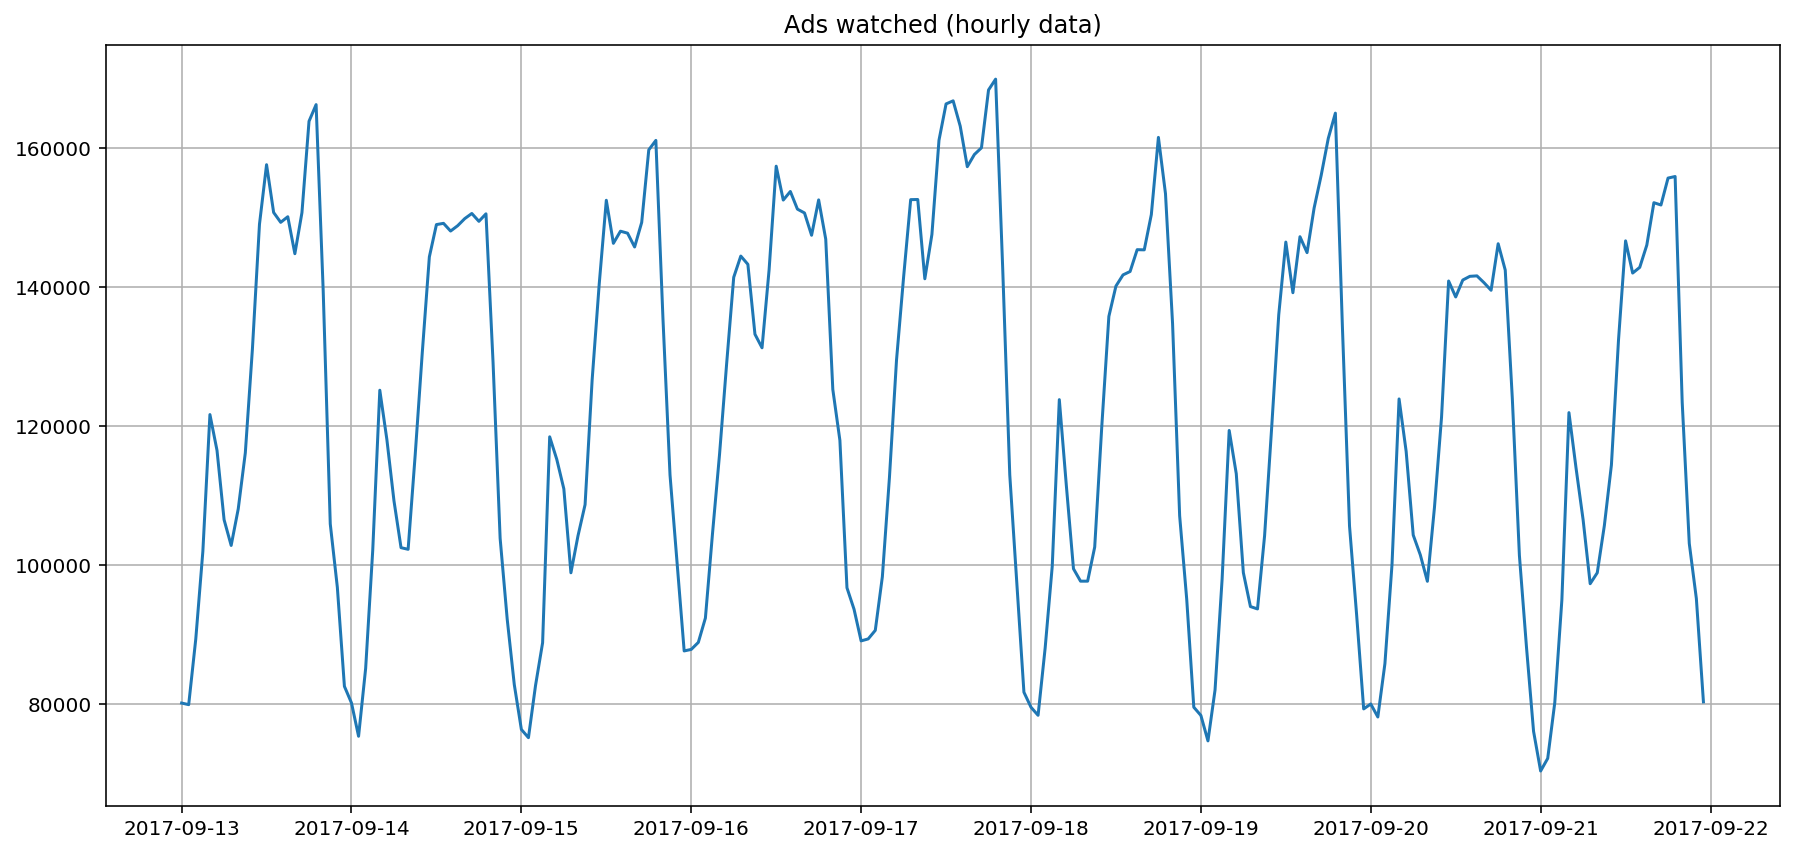

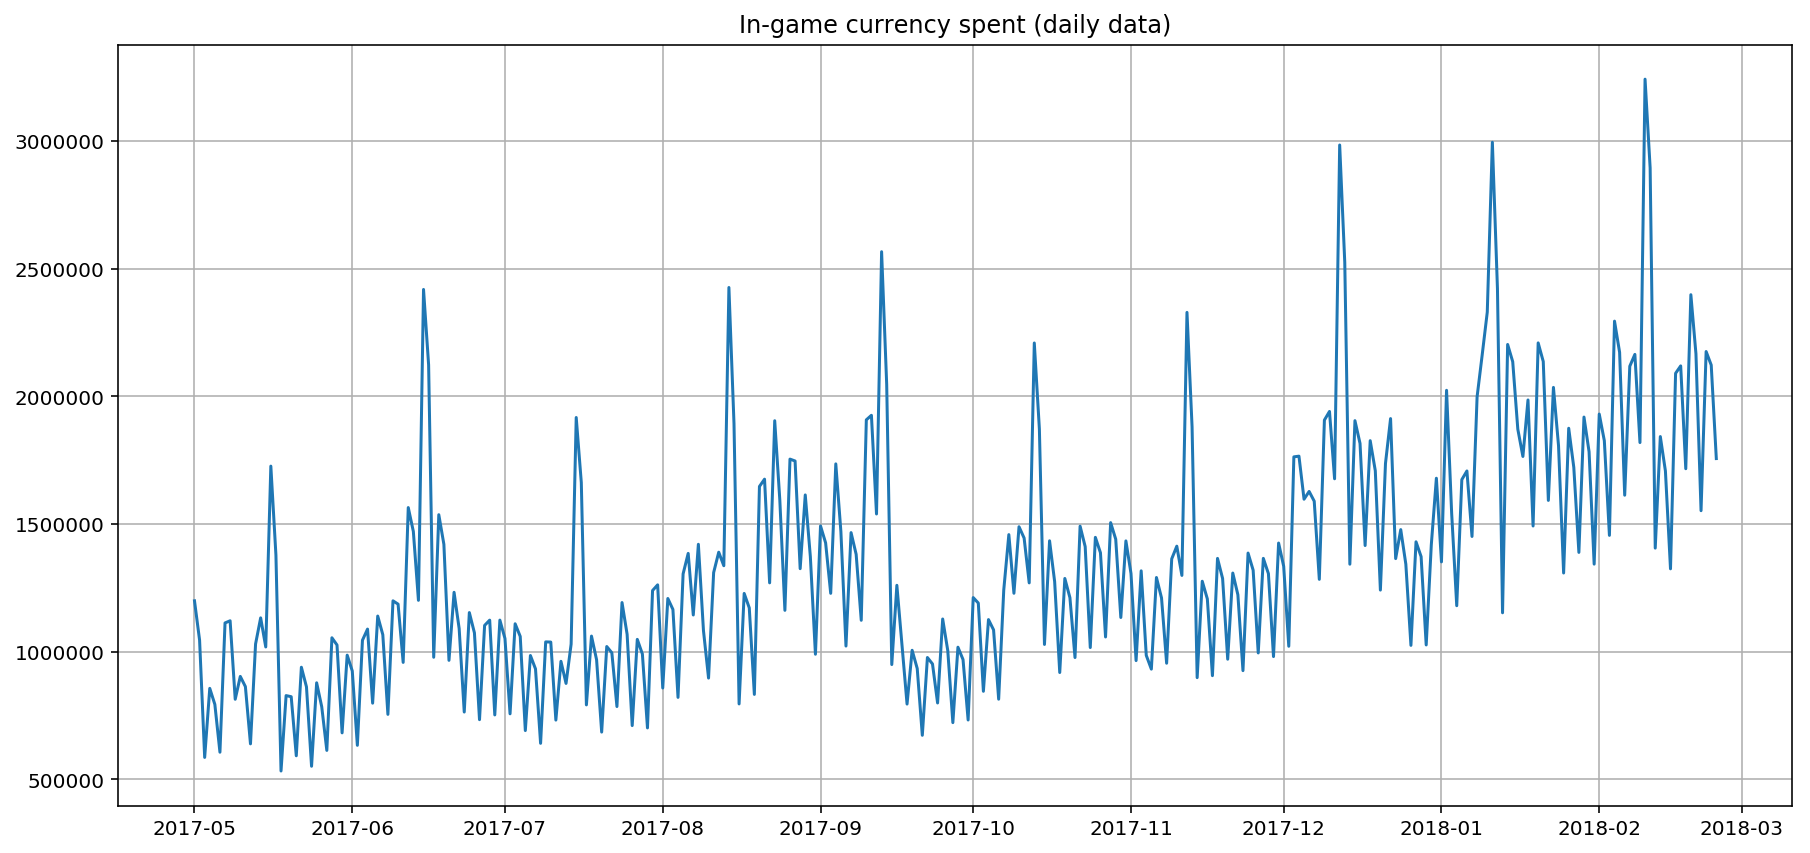

In [2]:
def plot(series, title):
    plt.figure(figsize=(15, 7))
    plt.plot(series)
    plt.title(title)
    plt.grid(True)

root_dir = Path("/tmp")
fetcher.WebFetcher.download_dataset("https://s3-eu-west-1.amazonaws.com/torchlite-datasets/mlopen_ads.csv", 
                                    root_dir.absolute(), False)
fetcher.WebFetcher.download_dataset("https://s3-eu-west-1.amazonaws.com/torchlite-datasets/mlopen_currency.csv", 
                                    root_dir.absolute(), False)
ads = pd.read_csv(root_dir / "mlopen_ads.csv", index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv(root_dir / "mlopen_currency.csv", index_col=['Time'], parse_dates=['Time'])

display(ads.head())
plot(ads["Ads"], 'Ads watched (hourly data)')

display(currency.head())
plot(currency["GEMS_GEMS_SPENT"], 'In-game currency spent (daily data)')

## Simple moving average

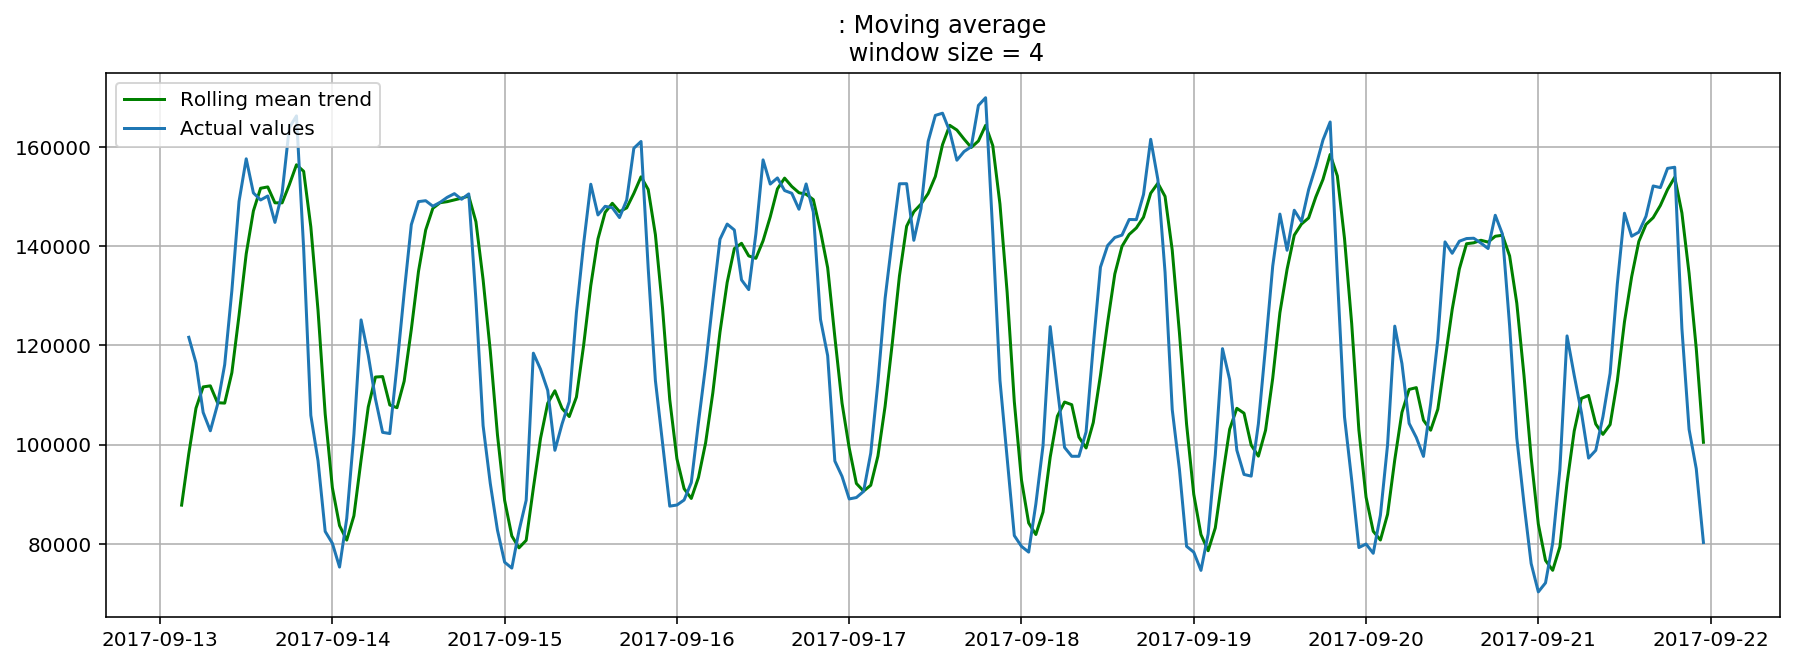

In [3]:
mv_o = tts.MovingAverage(ads["Ads"])
mv_rw = mv_o.get_simple_moving_average(4, show_plot=True)

## Exponential moving average

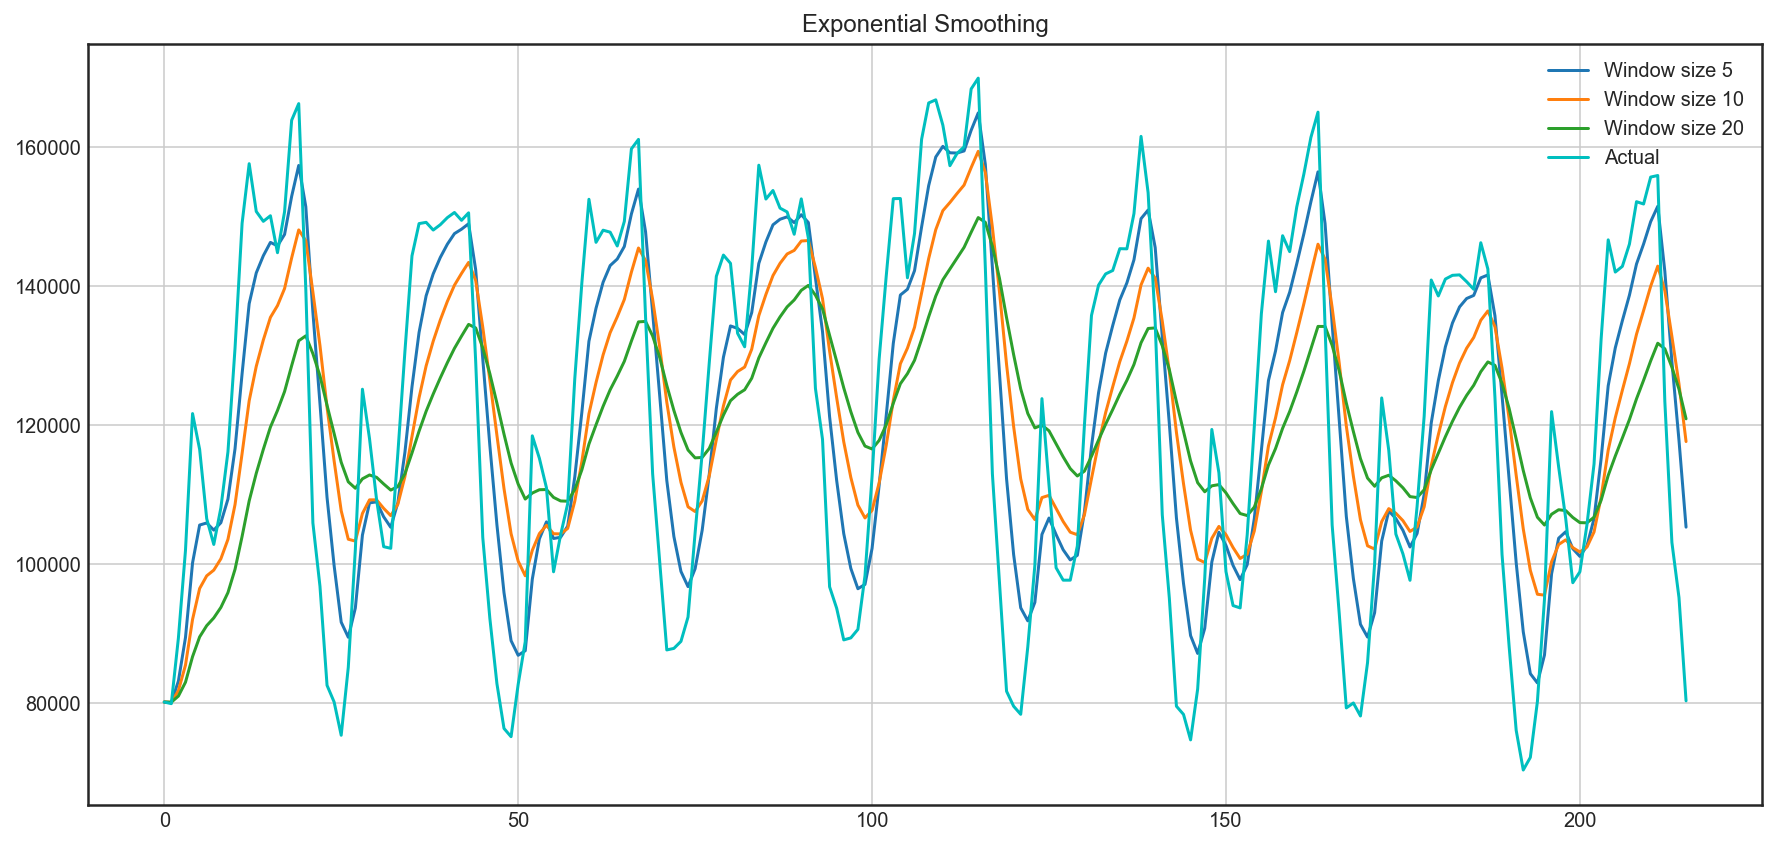

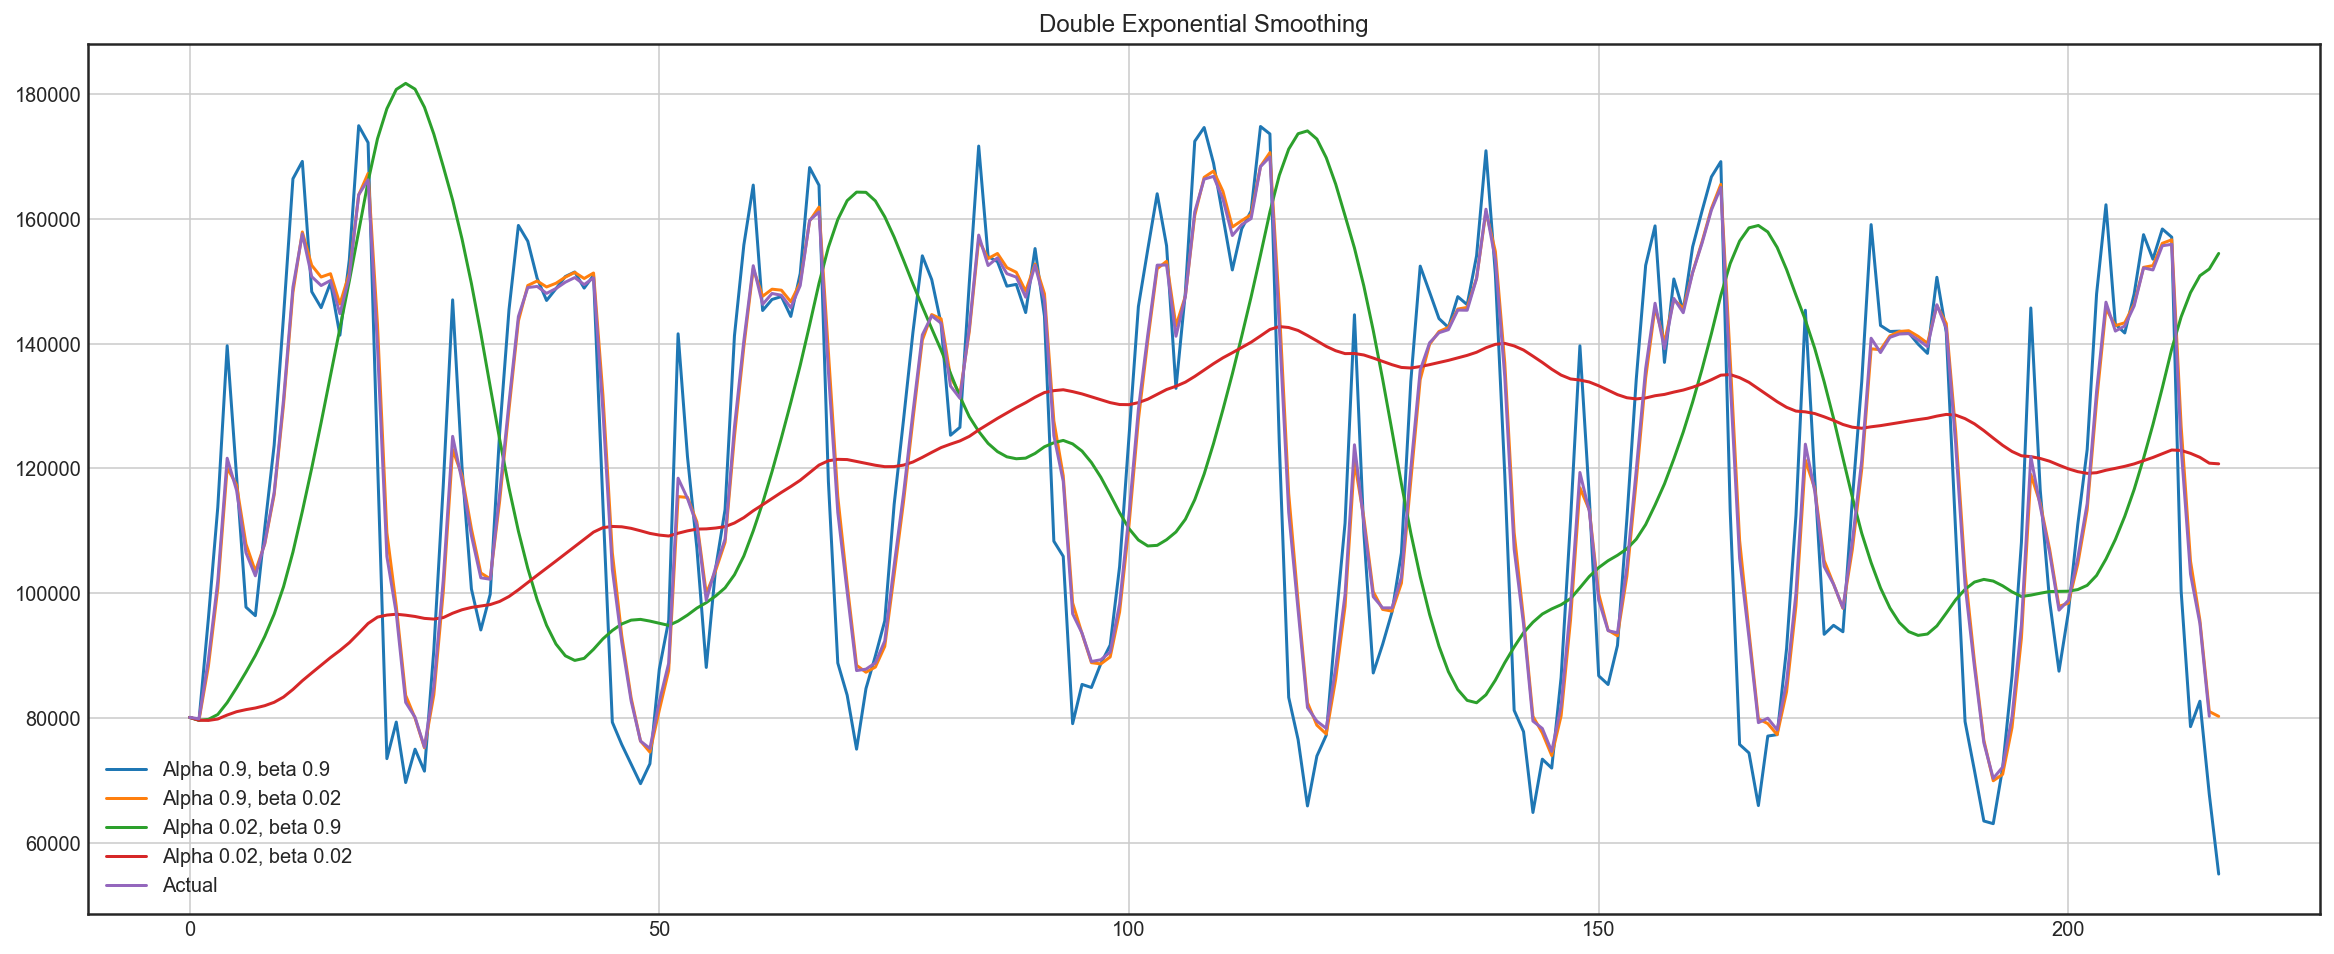

In [4]:
mv_o.plot_exponential_moving_average([5, 10, 20])
mv_o.plot_double_exponential_moving_average(alphas=[0.9, 0.02], betas=[0.9, 0.02])

## Triple exponential smoothing (a.k.a HoltWinters)

For time series problems with seasonality

Alpha: 0.052194537238485106, Beta: 0.0023555820090456203, Gamma: 0.04988712943035073


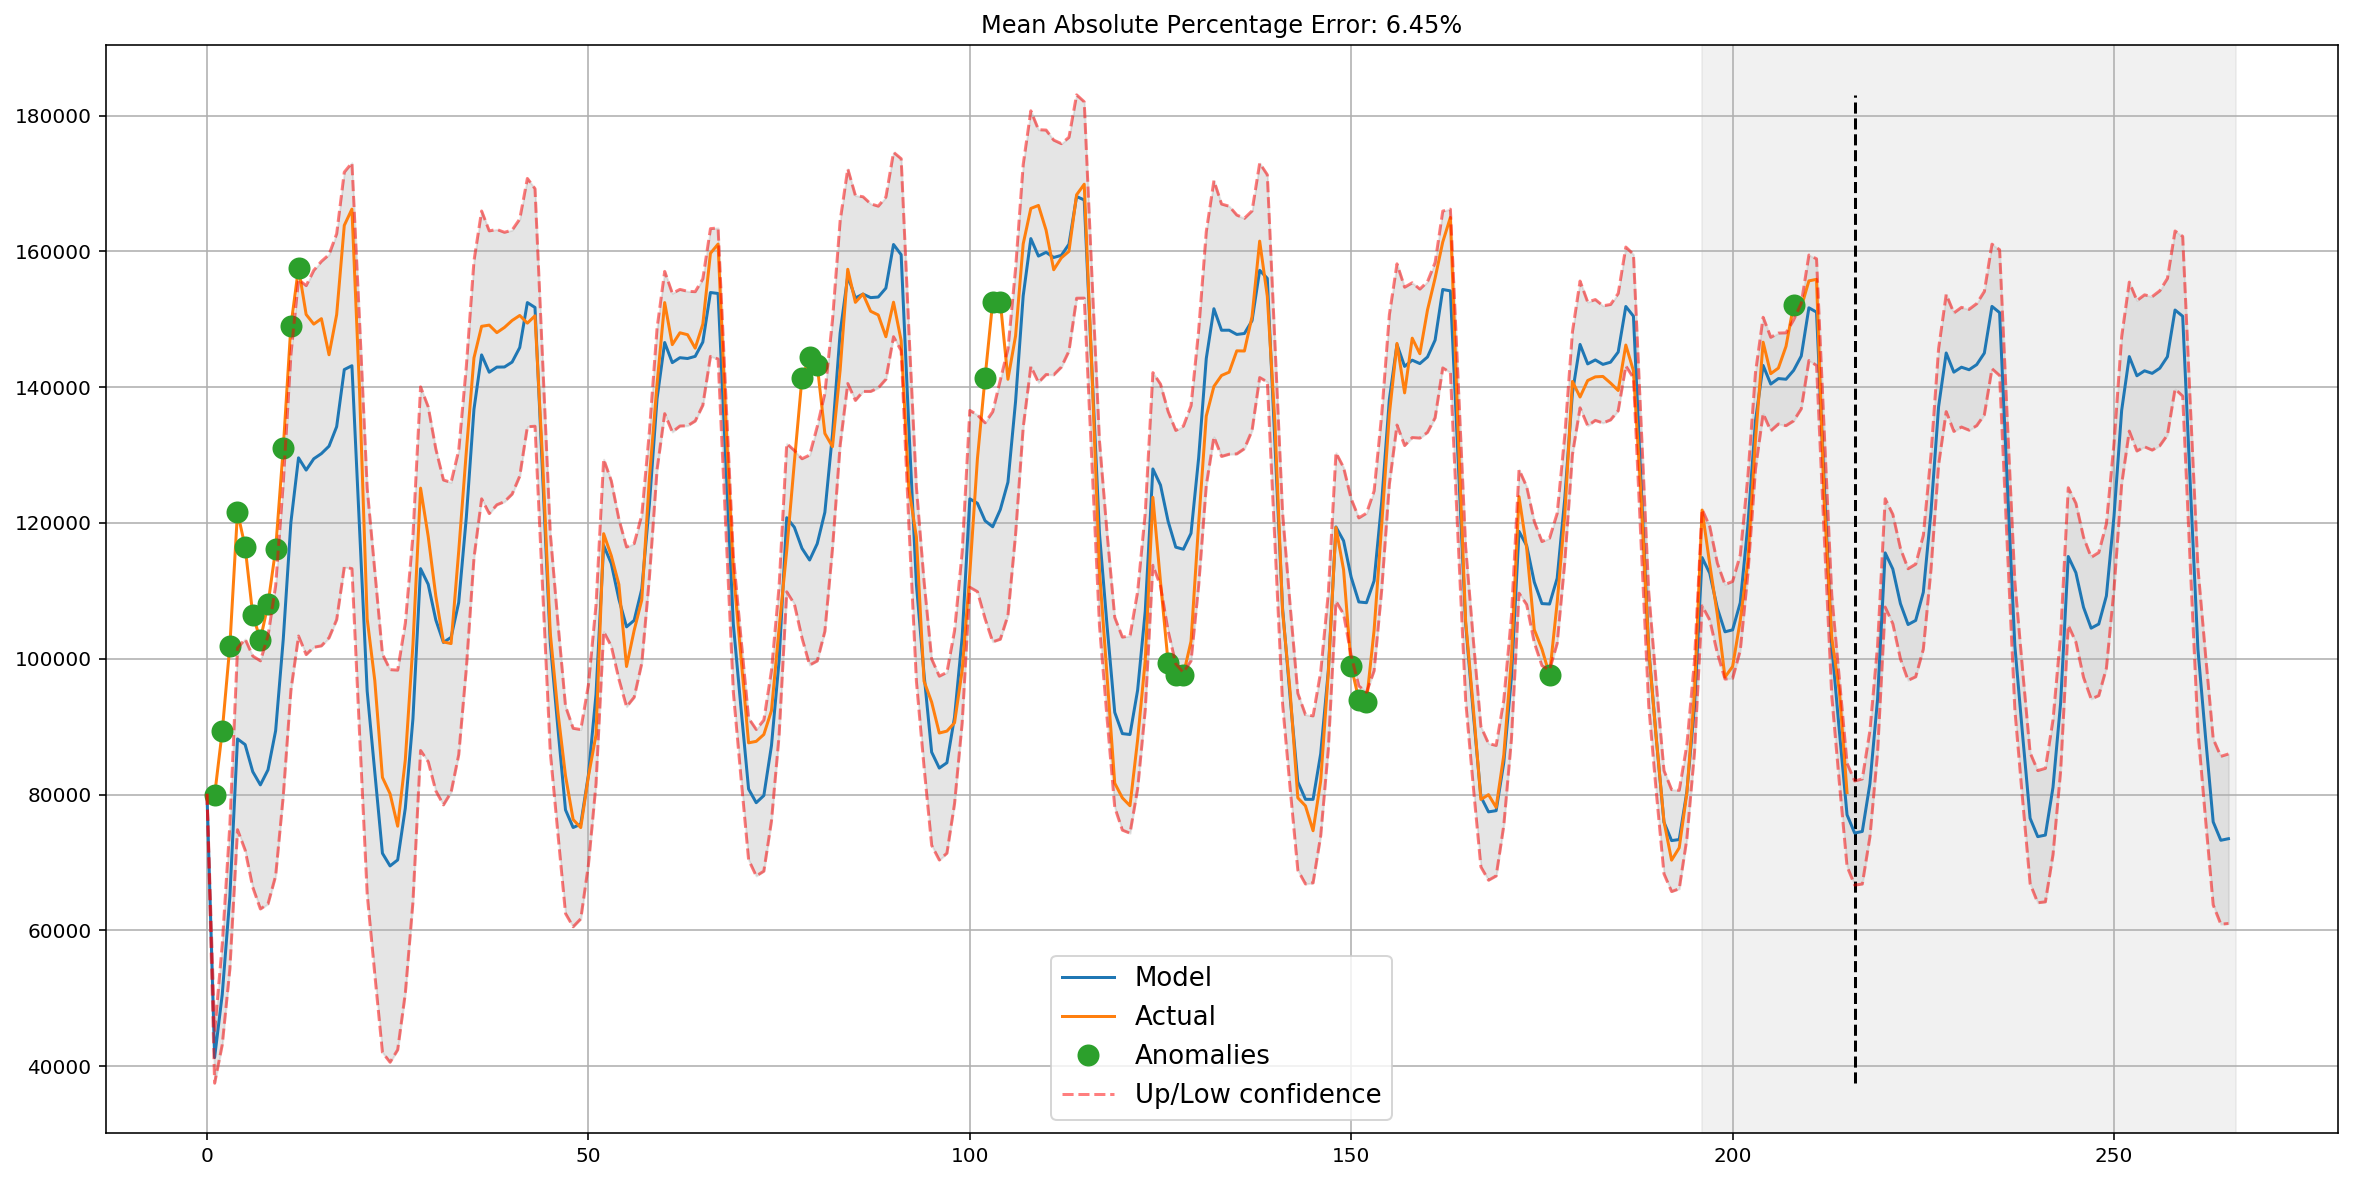

In [5]:
hw = tts.HoltWinters(ads["Ads"], slen=24, alpha=0, beta=0, gamma=0, n_preds=50)
hw.get_best_parameters(inplace=True)
output = hw.triple_exponential_smoothing(plot_results=True, plot_intervals=True, plot_anomalies=True)

Alpha: 0.011901303237625227, Beta: 0.05563459585439395, Gamma: 0.0


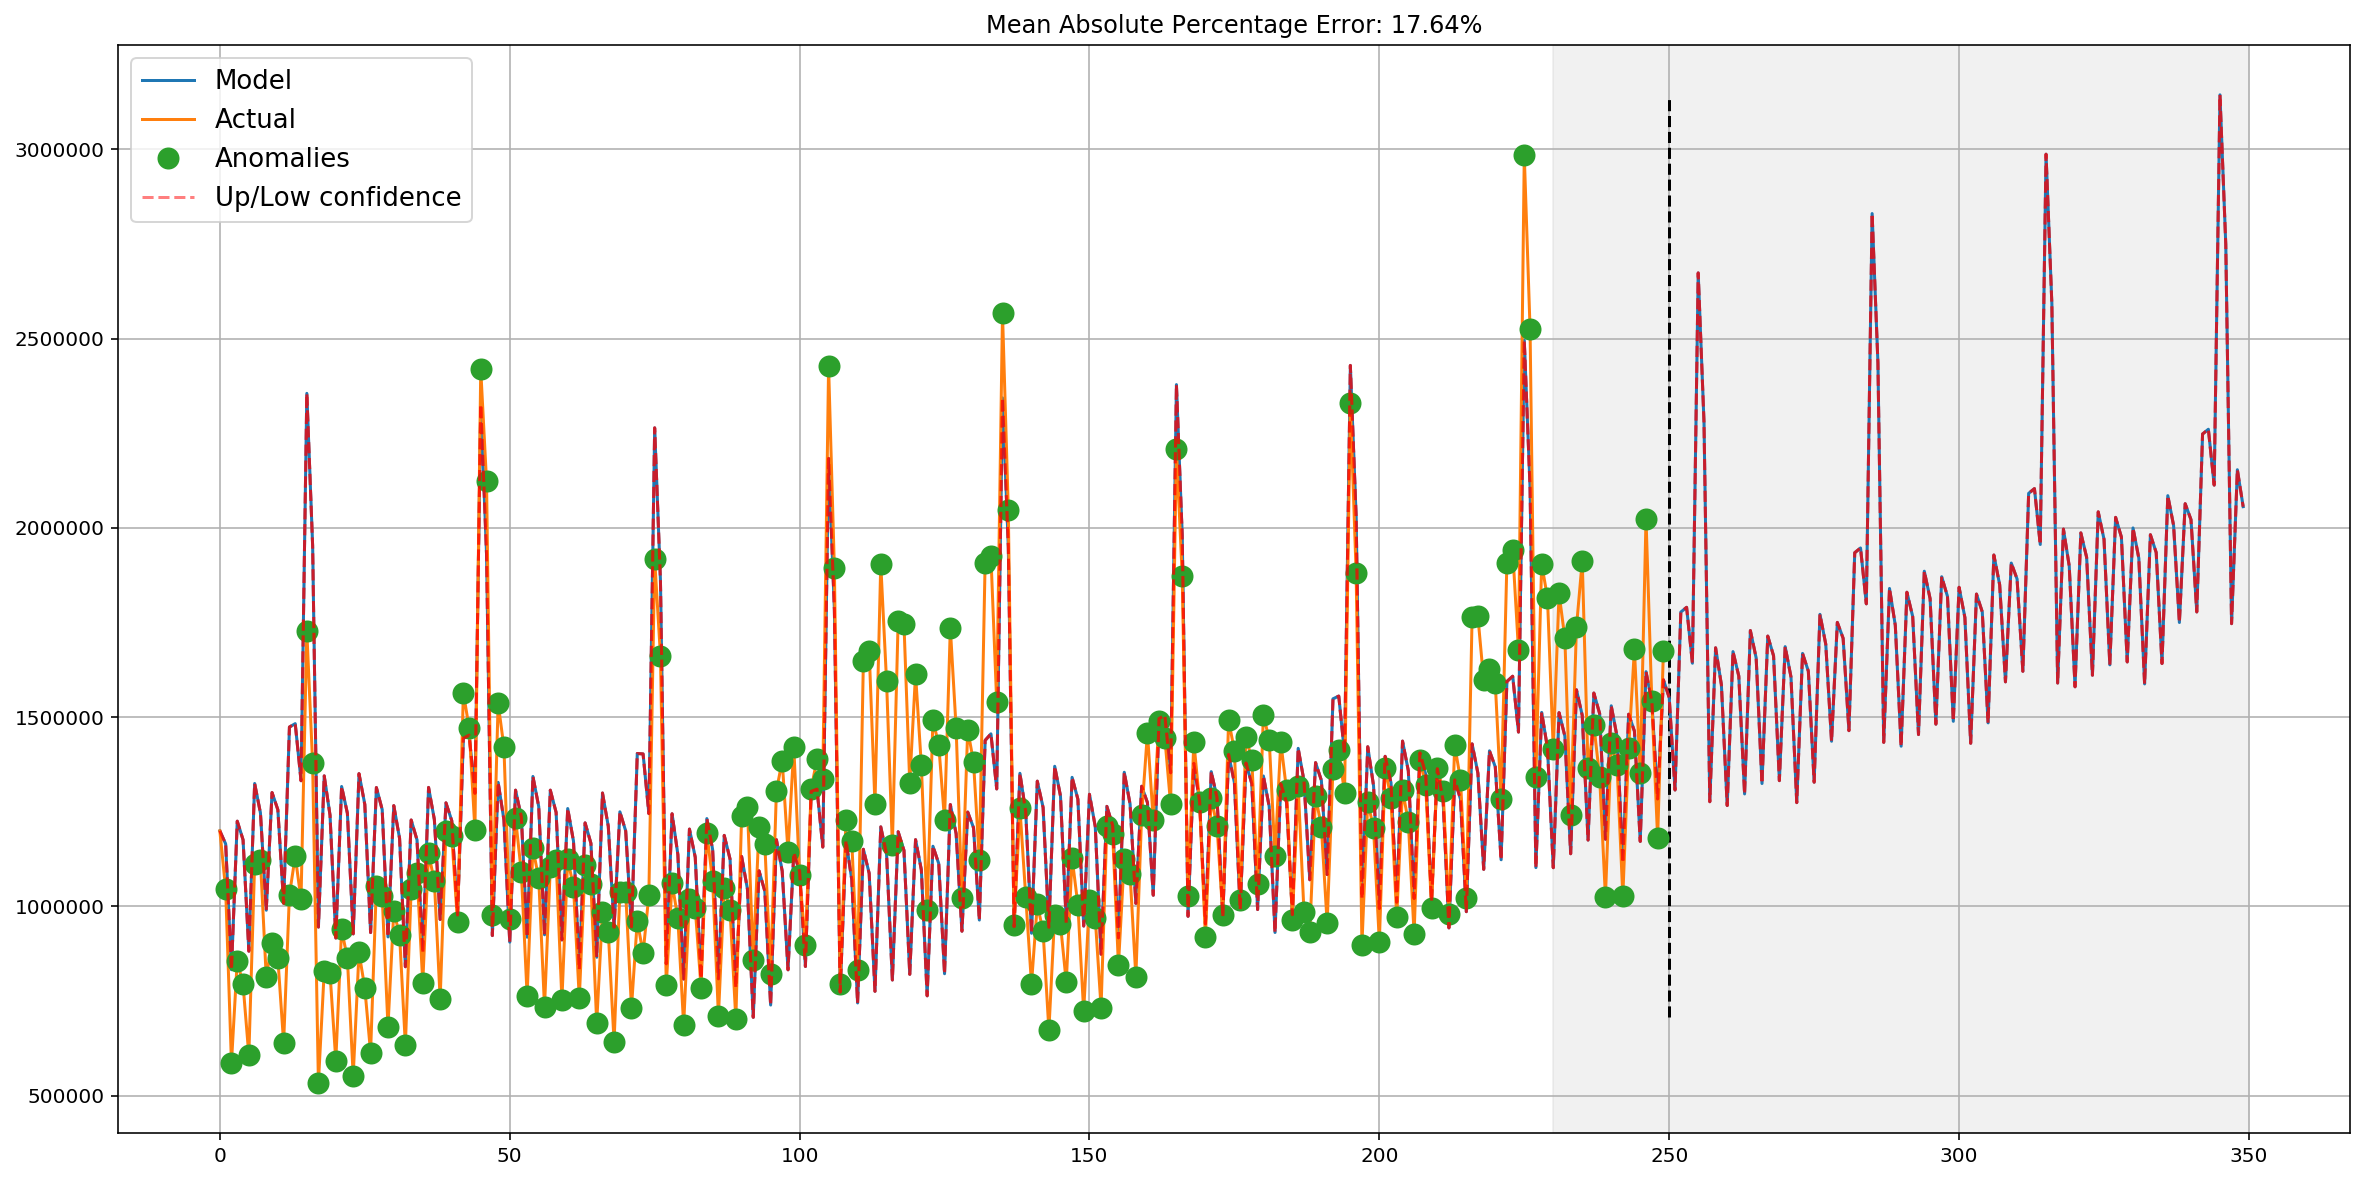

In [6]:
# HoltWinters
hw = tts.HoltWinters(currency["GEMS_GEMS_SPENT"][:-50], slen=30, alpha=0, beta=0, gamma=0, n_preds=100)
hw.get_best_parameters(inplace=True)
output = hw.triple_exponential_smoothing(plot_results=True, plot_intervals=True, plot_anomalies=True)

## Making data stationary

/Users/Ekami/Programs/anaconda/envs/dl/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


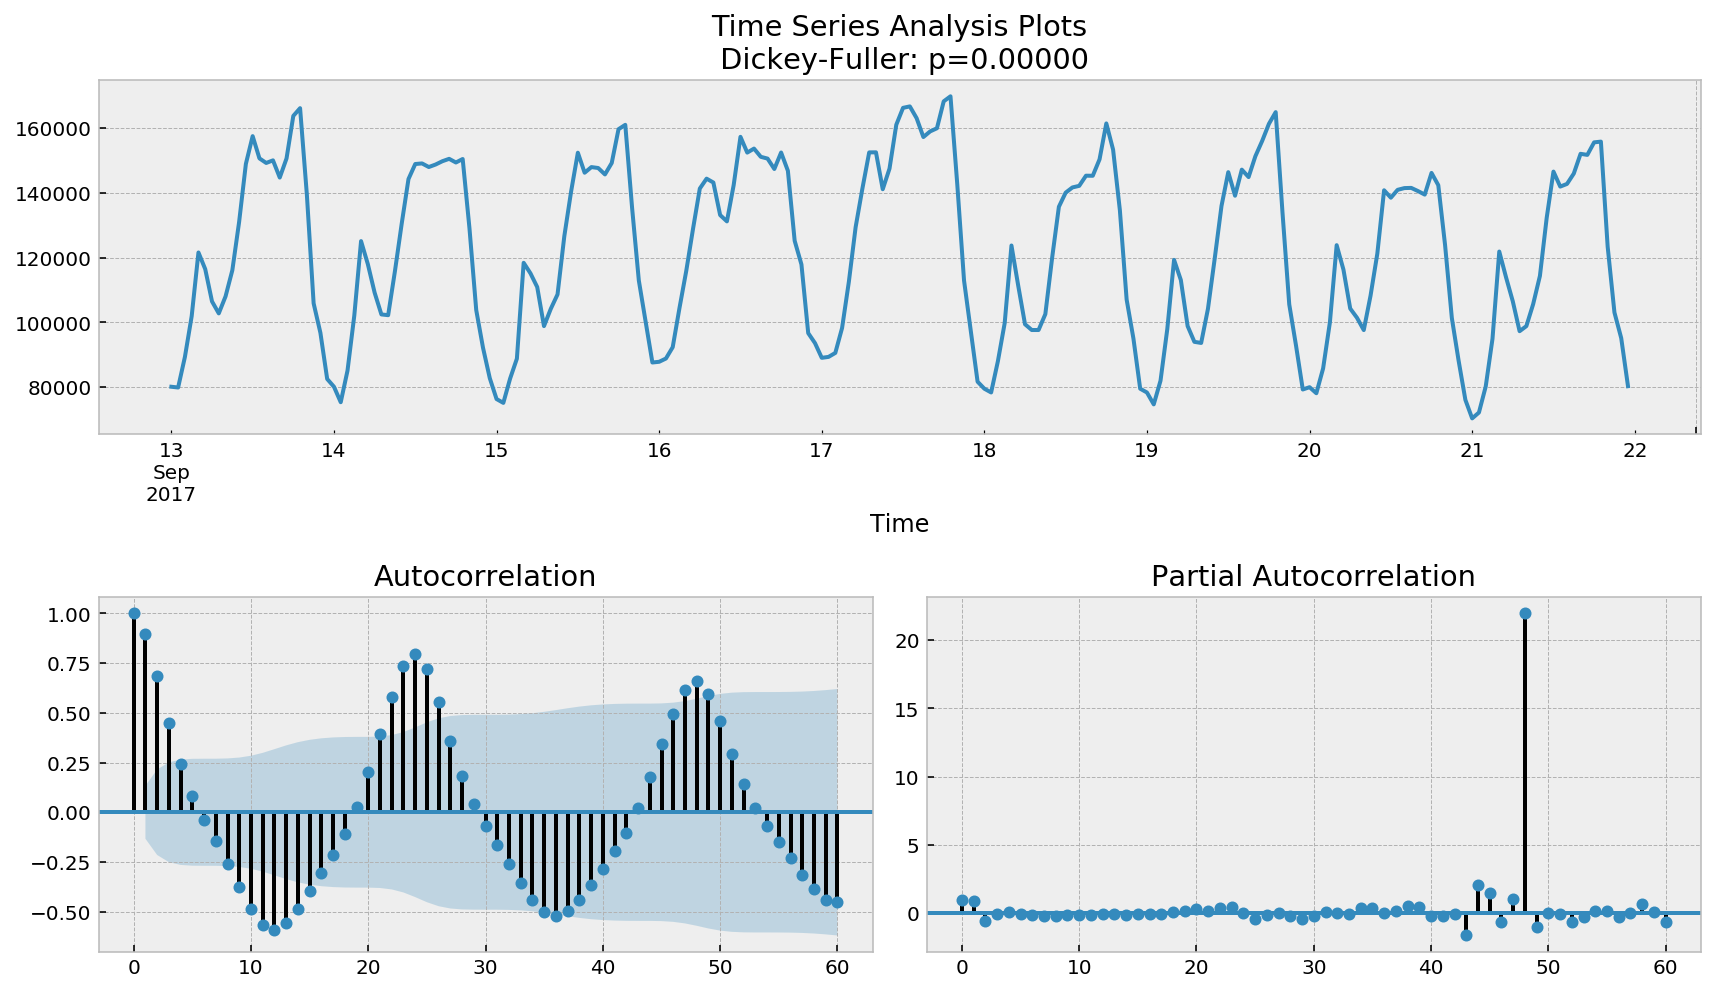

(4.444803688622434e-10, True)

In [7]:
tts.test_stationary(ads["Ads"], lags=60)

Our data is not stationary as the p-value <= 0.05 but it still has seasonality that we need to get rid of. Let's take the "seasonal difference", which means a simple subtraction of the series from itself with a lag that equals the seasonal period.

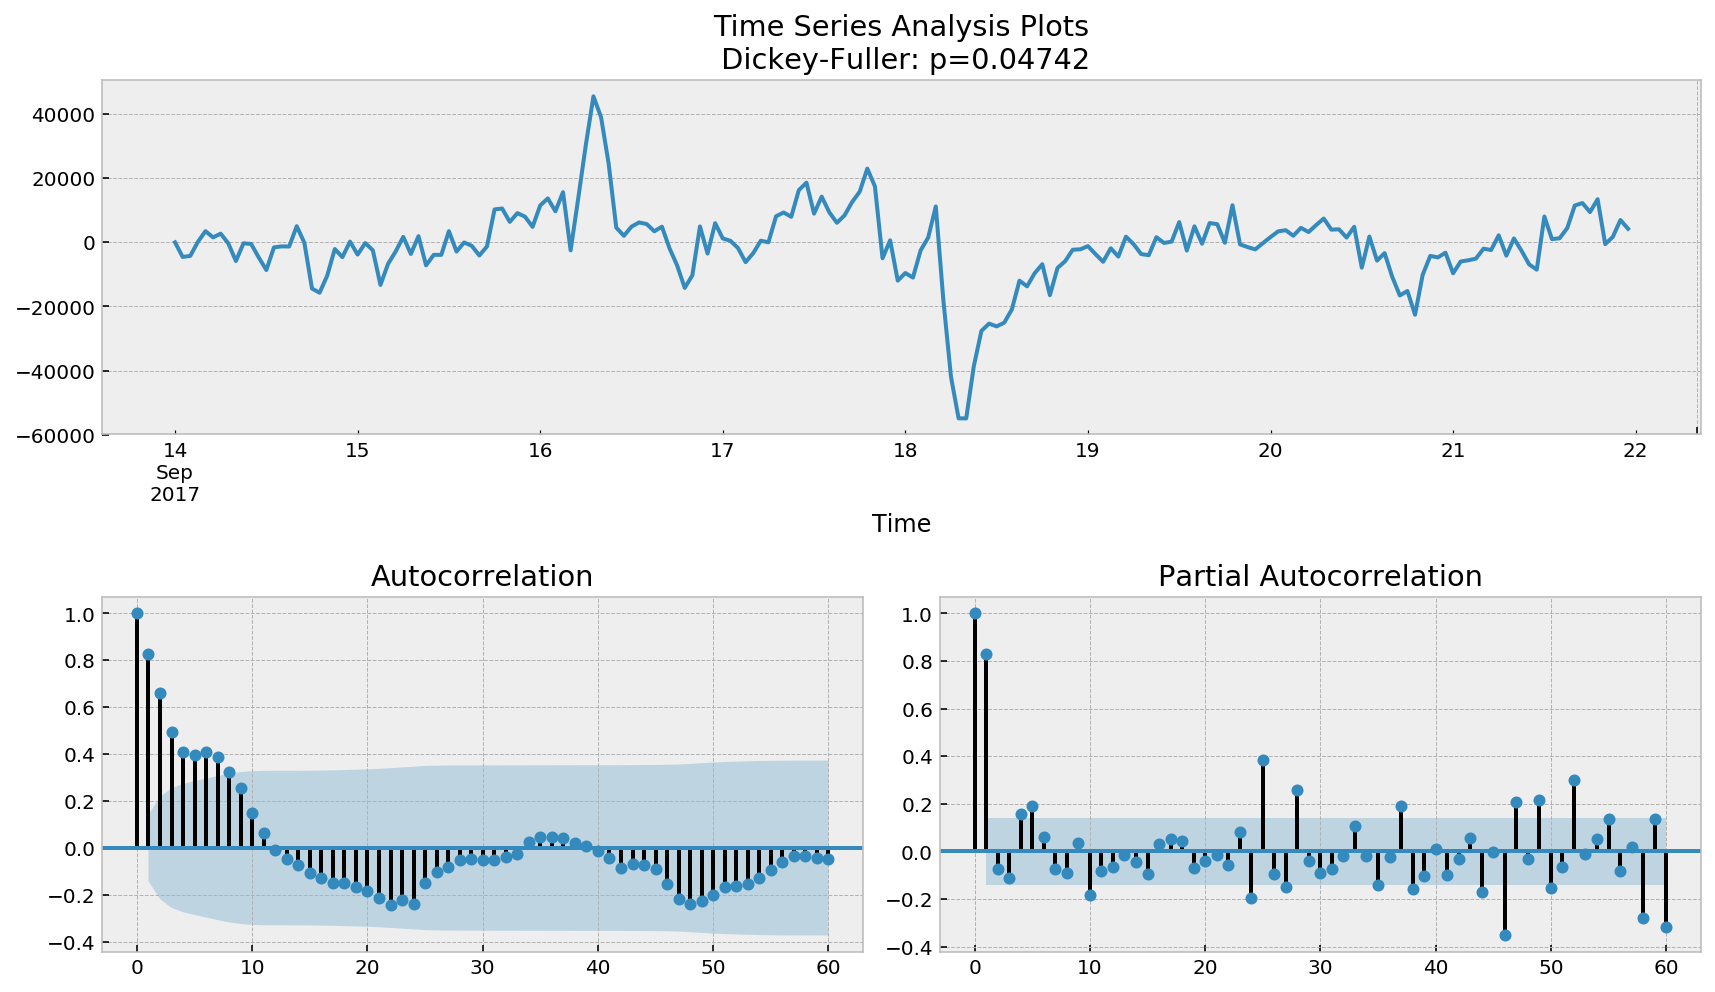

(0.04741727130172205, True)

In [8]:
ads_diff = ads.Ads - ads.Ads.shift(24)
tts.test_stationary(ads_diff[24:], lags=60)

It is now much better with the visible seasonality gone. However, the autocorrelation function still has too many significant lags. To remove them, we'll take first differences, subtracting the series from itself with lag 1.

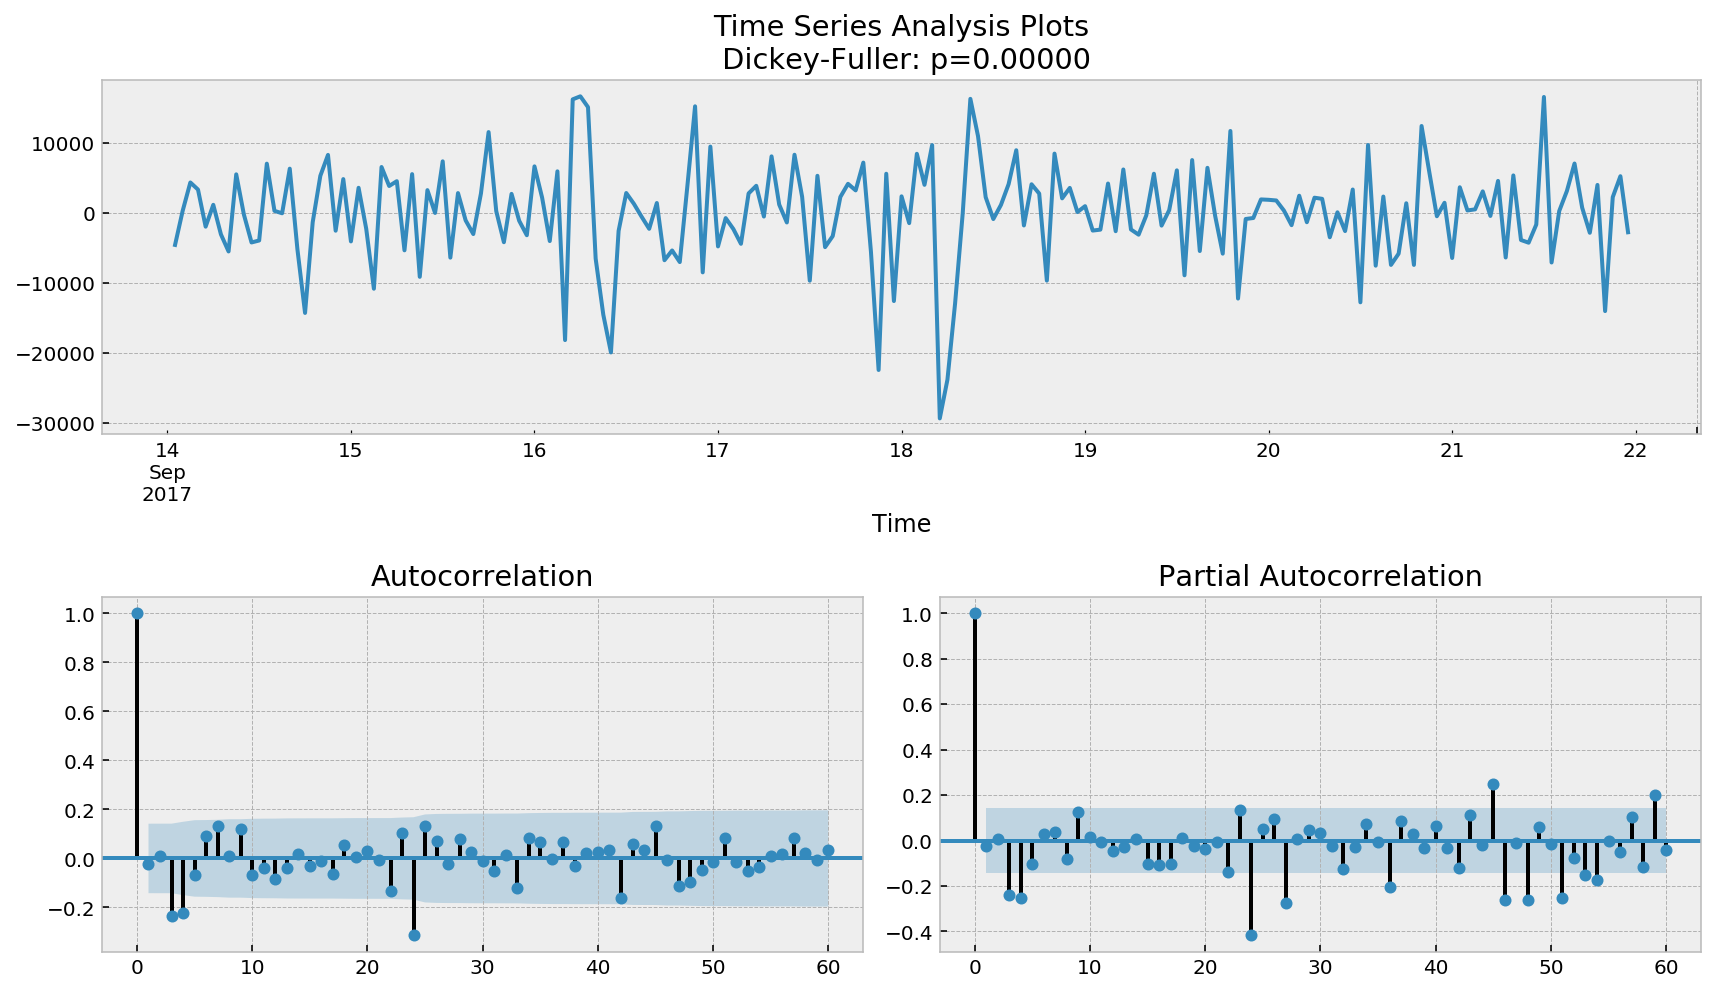

(3.229517979418641e-18, True)

In [9]:
ads_diff = ads_diff - ads_diff.shift(1)
tts.test_stationary(ads_diff[24+1:], lags=60)

Perfect! Our series now looks like something undescribable, oscillating around zero. The Dickey-Fuller test indicates that it is stationary, and the number of significant peaks in ACF has dropped. We can finally start modeling!

## SARIMA

In [10]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

sarima = tts.SARIMAX(ads["Ads"], d, D, s)
best_model = sarima.optimize(parameters_list)

 81%|████████  | 29/36 [01:23<00:20,  2.86s/it]/Users/Ekami/Programs/anaconda/envs/dl/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 86%|████████▌ | 31/36 [01:36<00:15,  3.12s/it]/Users/Ekami/Programs/anaconda/envs/dl/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
100%|██████████| 36/36 [01:49<00:00,  3.03s/it]
/Users/Ekami/Programs/anaconda/envs/dl/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [11]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(0, 1, 1, 24)   Log Likelihood               -1941.585
Date:                            Wed, 16 May 2018   AIC                           3897.171
Time:                                    12:17:03   BIC                           3919.937
Sample:                                09-13-2017   HQIC                          3906.392
                                     - 09-21-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7653      0.223      3.436      0.001       0.329       1.202
ar.L2         -0.5354      0.263     -2.037      0.042      -1.051      -0.020
ma.L1         -0.7010      0.212     -3.300      0.001      -1.117      -0.285
ma.L2          0.5559      0.234      2.378      0.017       0.098       1.014
ma.L3         -0.2164      0.087     -2.481      0.013      -0.387      -0.045
ma.S.L24      -0.4431      0.043    -10.281      0.000      -0.528      -0.359
sigma2      4.574e+07    7.1e-09   6.44e+15      0.000    4.57e+07    4.57e+07
===================================================================================
Ljung-Box (Q):                       40.54   Jarque-Bera (JB):                55.13
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.56e+31. Standard errors may be unstable.
"""

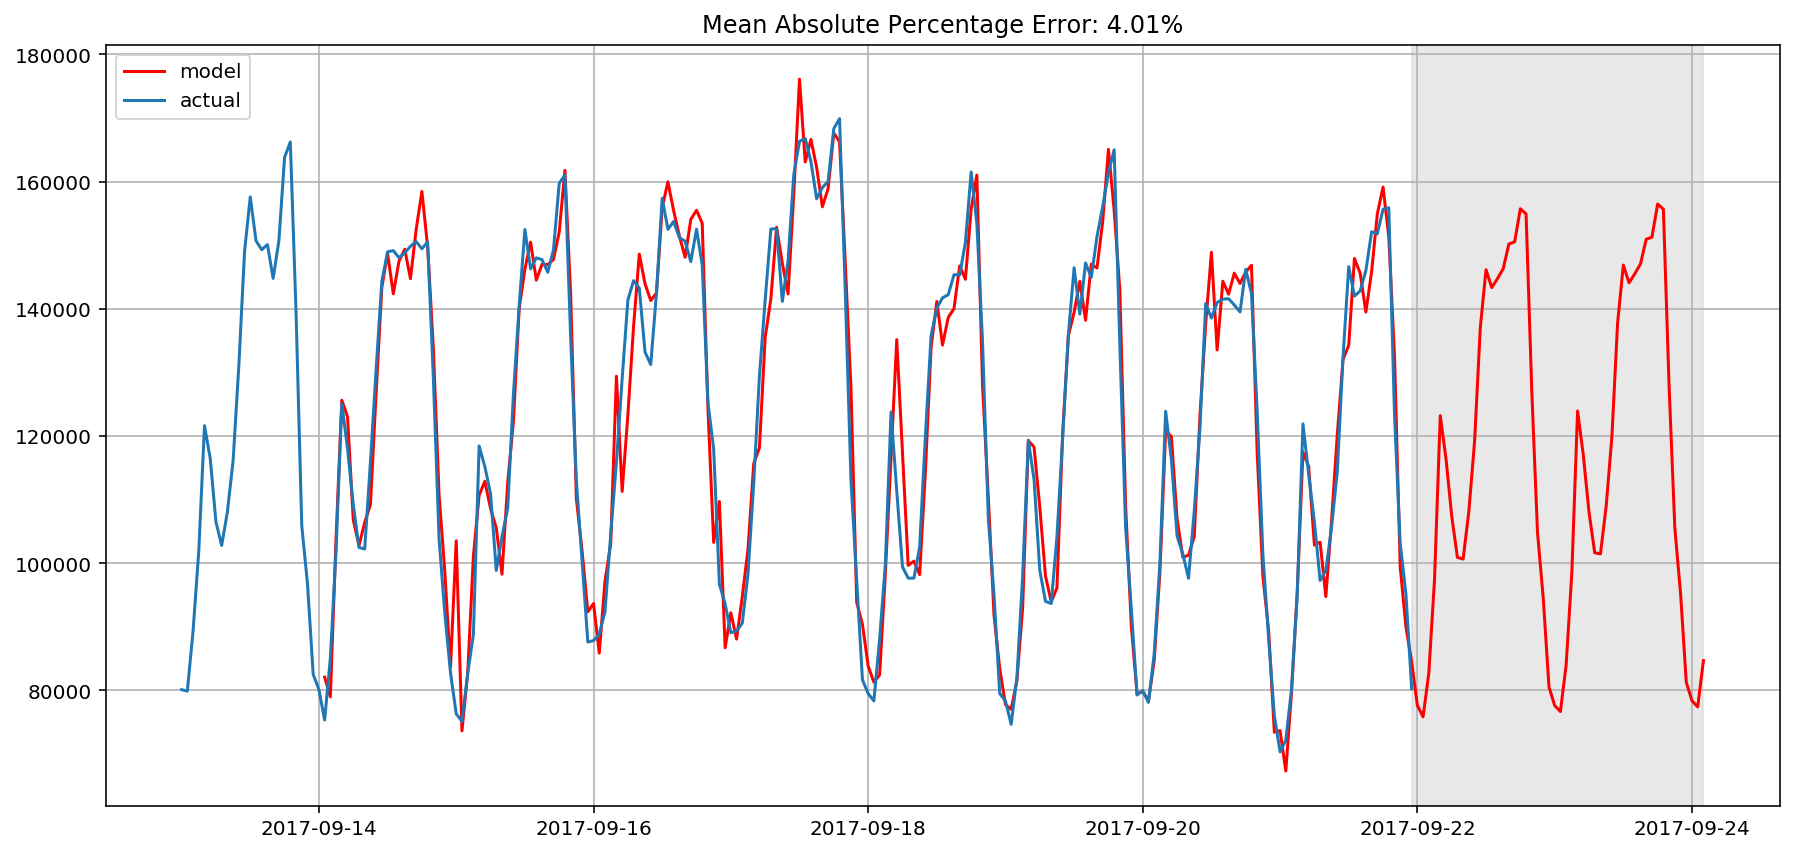

In [12]:
sarima.plot(best_model, 50)

## Simple linear regression

Here we will only use a simple linear regression an compare its MAP to SARIMA

In [13]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test


def code_mean(data, cat_feature, real_feature):
    """
        Returns a dictionary where keys are unique categories of the cat_feature,
        and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())


def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # drop encoded variables 
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,is_weekend,weekday_average,hour_average
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-18 16:00:00,119930.0,102565.0,97655.0,97655.0,99440.0,111325.0,123780.0,99790.0,88045.0,78350.0,...,97345.0,112955.0,142710.0,169900.0,168345.0,160020.0,159055.0,0,108260.714286,150012.0
2017-09-18 17:00:00,135755.0,119930.0,102565.0,97655.0,97655.0,99440.0,111325.0,123780.0,99790.0,88045.0,...,81675.0,97345.0,112955.0,142710.0,169900.0,168345.0,160020.0,0,108260.714286,151600.0
2017-09-18 18:00:00,140120.0,135755.0,119930.0,102565.0,97655.0,97655.0,99440.0,111325.0,123780.0,99790.0,...,79510.0,81675.0,97345.0,112955.0,142710.0,169900.0,168345.0,0,108260.714286,158775.0
2017-09-18 19:00:00,141730.0,140120.0,135755.0,119930.0,102565.0,97655.0,97655.0,99440.0,111325.0,123780.0,...,78350.0,79510.0,81675.0,97345.0,112955.0,142710.0,169900.0,0,108260.714286,158923.0
2017-09-18 20:00:00,142220.0,141730.0,140120.0,135755.0,119930.0,102565.0,97655.0,97655.0,99440.0,111325.0,...,88045.0,78350.0,79510.0,81675.0,97345.0,112955.0,142710.0,0,108260.714286,134425.0


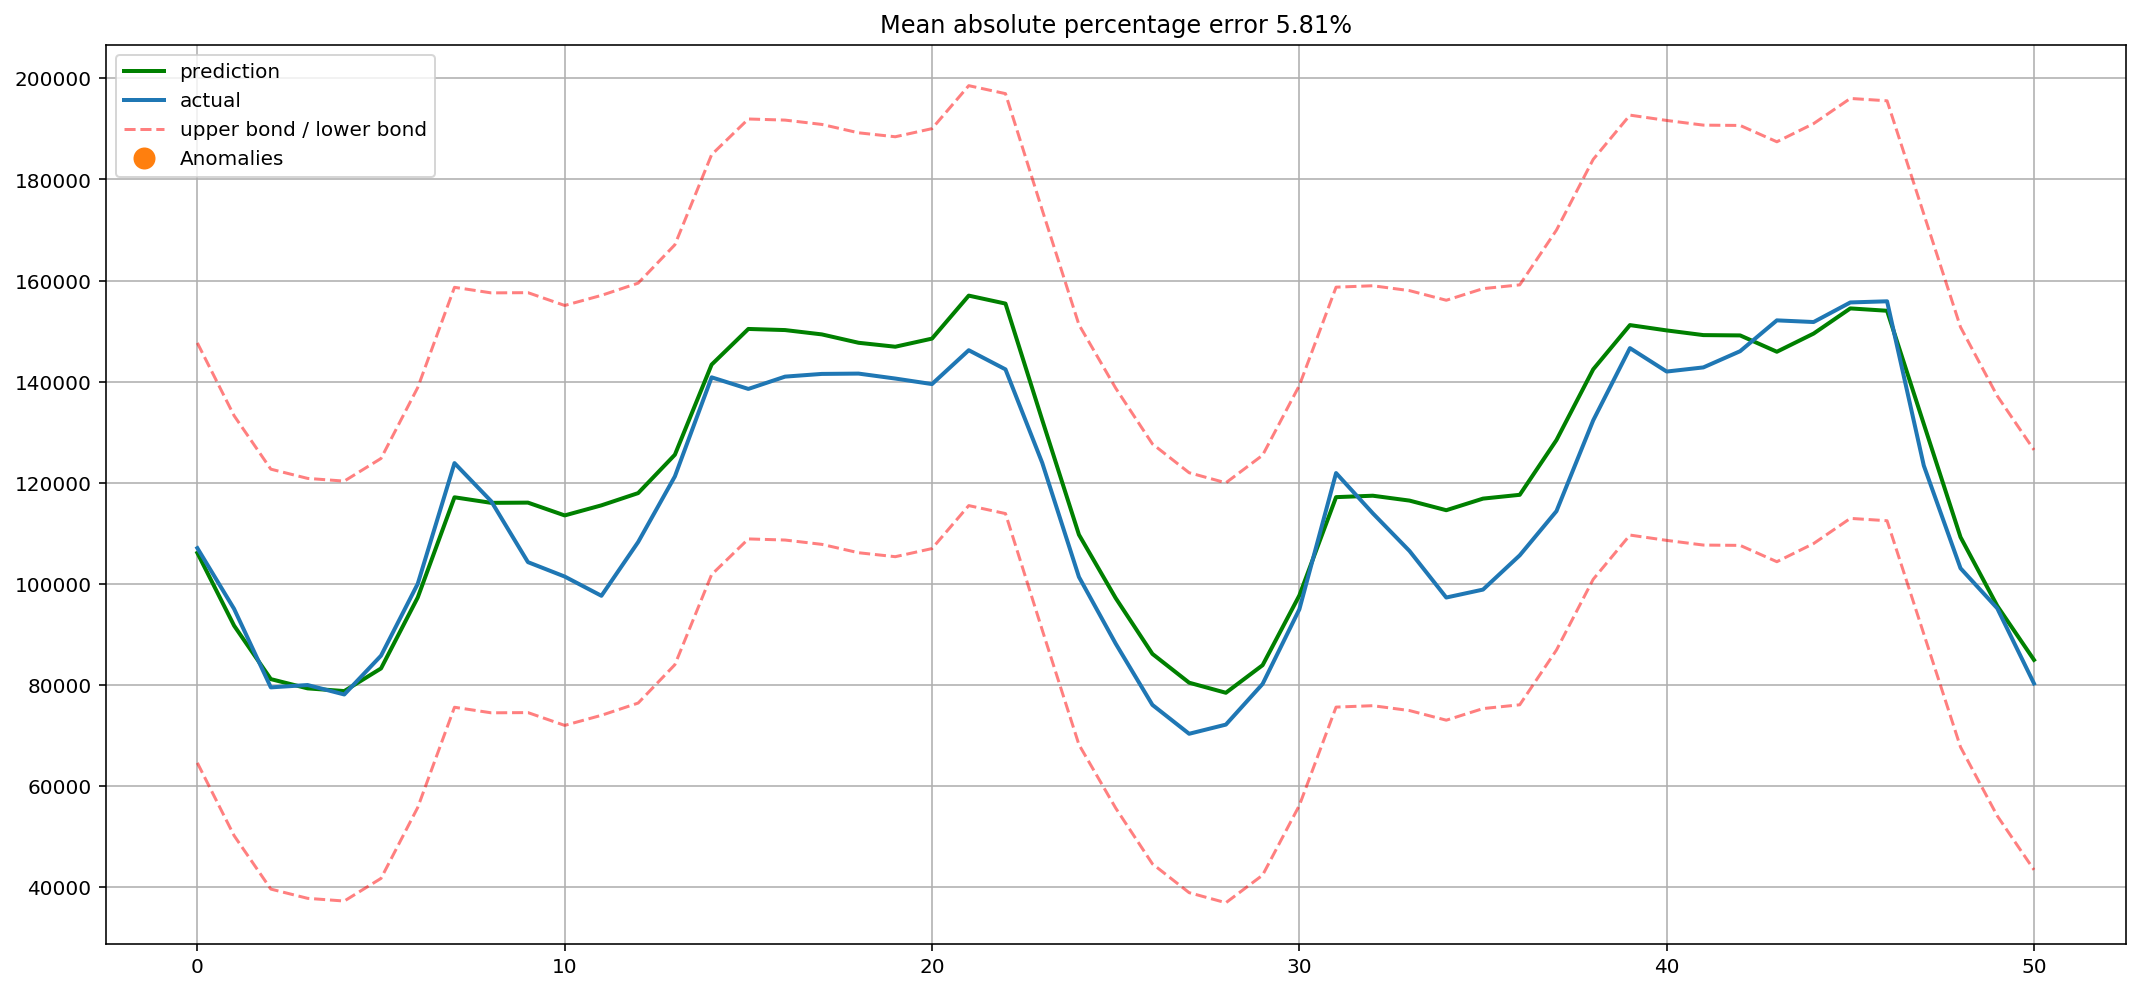

<class 'pandas.core.frame.DataFrame'>


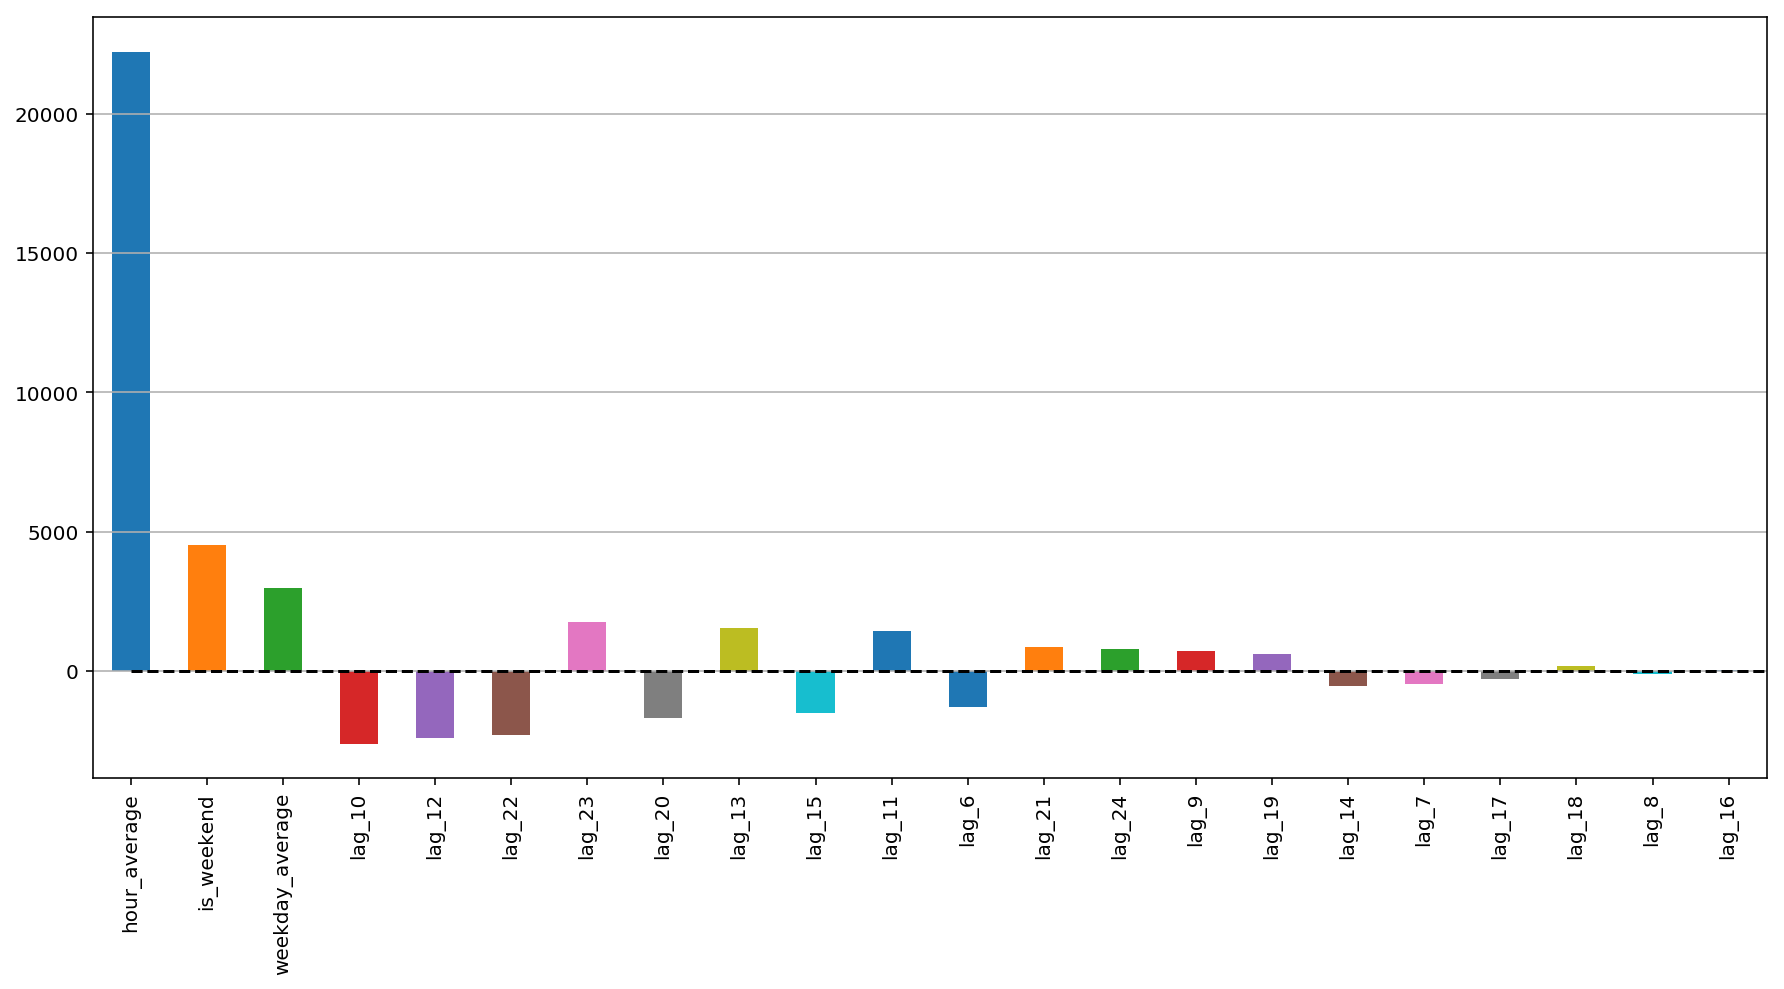

In [15]:
X_train, X_test, y_train, y_test = \
    prepareData(ads["Ads"], lag_start=6, lag_end=25, test_size=0.3, target_encoding=True)

display(X_train.tail())

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

tscv = TimeSeriesSplit(n_splits=5)
helper = tmplot.LinearModelsHelper(lr, X_train_scaled, y_train)
helper.plot_model_results(X_test_scaled, y_test, tscv, plot_intervals=True, plot_anomalies=True)
helper.plot_coefficients(X_train.columns)

We see some **overfitting**! `Hour_average` was so great in the training dataset that the model decided to concentrate all of its forces on it. As a result, the quality of prediction dropped. This problem can be solved in a variety of ways; for example, we can calculate the target encoding not for the whole train set, but for some window instead. That way, encodings from the last observed window will most likely better describe the current series state. Alternatively, we can just drop it manually since we are sure that it makes things only worse in this case. 